# Libraries

In [81]:
import heapq
import random
import math
import time
import itertools
import statistics
import matplotlib.pyplot as plt
from collections import defaultdict, deque

# Utility Functions

In [82]:
def is_solvable(state):
    """
    Check if a given 8-puzzle state is solvable.
    A state is solvable if the number of inversions is even.
    """
    inversions = 0
    tiles = [tile for tile in state if tile != 0]  # Exclude the blank tile (0)

    for i in range(len(tiles)):
        for j in range(i + 1, len(tiles)):
            if tiles[i] > tiles[j]:
                inversions += 1

    return inversions % 2 == 0


def generate_random_state():
    """
    Generate a random solvable starting state for the 8-puzzle.
    """
    state = list(range(9))  # Numbers 0 to 8
    random.shuffle(state)  # Shuffle the tiles randomly

    while not is_solvable(state):
        random.shuffle(state)  # Reshuffle if the state is not solvable

    return tuple(state)

In [83]:
# Defining the 8-puzzle
goal_state = (1, 2, 3, 4, 5, 6, 7, 8, 0)  # Solved puzzle

In [84]:
# Define valid moves for the 8-puzzle
# returns list of states (max 4)
def get_neighbors(state):
    neighbors = []
    empty_idx = state.index(0)
    x, y = empty_idx // 3, empty_idx % 3
    
    moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right
    for dx, dy in moves:
        nx, ny = x + dx, y + dy
        if 0 <= nx < 3 and 0 <= ny < 3:  # Check if within bounds
            new_pos = nx * 3 + ny
            new_state = list(state)
            new_state[empty_idx], new_state[new_pos] = new_state[new_pos], new_state[empty_idx]
            neighbors.append(tuple(new_state))
    return neighbors


In [85]:
def display(result):
    """
    Display detailed information about the Greedy Best-First Search result.
    """
    path, nodes_expanded = result  # Unpack result
    if path is None:
        print("No solution was found.")
        print(f"Number of states visited: {nodes_expanded}")
    else:
        cost_of_solution = len(path) - 1  # Cost is the number of moves (edges in the path)
        moves = generate_moves(path)
        print("Solution found!")
        print(f"Number of nodes expanded: {nodes_expanded}")
        print(f"Cost of the solution (number of moves): {cost_of_solution}")
        #print(f"Moves to solve (u=up, d=down, l=left, r=right): {''.join(moves)}")
        #print(f"Solution path (start to goal):")
        #for state in path:
        #    print(state)


def generate_moves(path):
    """
    Generate a list of moves for the blank space (0) to solve the puzzle.
    Symbols:
    - 'U': up
    - 'D': down
    - 'L': left
    - 'R': right
    """
    moves = []
    for i in range(1, len(path)):
        prev_state = path[i - 1]
        curr_state = path[i]

        # Find positions of the empty space (0)
        prev_pos = prev_state.index(0)
        curr_pos = curr_state.index(0)

        # Calculate row and column differences
        prev_row, prev_col = divmod(prev_pos, 3)
        curr_row, curr_col = divmod(curr_pos, 3)

        # Determine the direction of movement (opposite of the movement of empty tile)
        if curr_row < prev_row:
            moves.append('D')  # Up
        elif curr_row > prev_row:
            moves.append('U')  # Down
        elif curr_col < prev_col:
            moves.append('R')  # Left
        elif curr_col > prev_col:
            moves.append('L')  # Right)

    return moves

# Heuristics

In [86]:
# Heuristic for Dijkstra: 0
def h0(state):
    return 0


# Heuristic: Manhattan distance
def h_manhattan(state):
    distance = 0
    for i in range(9):
        if state[i] != 0:  # Skip the empty space
            goal_idx = goal_state.index(state[i])  # index of the tile in goal
            x1, y1 = i // 3, i % 3 # current position (row, column)
            x2, y2 = goal_idx // 3, goal_idx % 3 # goal position (row, column)
            distance += abs(x1 - x2) + abs(y1 - y2)
    return distance

# Heuristic: # wrong tiles
def h_wrong(state):
    count = 0
    for i in range(9):
        if state[i]!=0 and state[i] != goal_state[i]: 
            count+=1
    return count

# Heuristic: Euclidean distance
def h_euclidean(state):
    distance = 0
    for i in range(9):
        if state[i] != 0:  # Skip the empty space (0)
            goal_idx = goal_state.index(state[i])  # index of the tile in the goal
            x1, y1 = i // 3, i % 3  # current position (row, column)
            x2, y2 = goal_idx // 3, goal_idx % 3  # goal position (row, column)
            distance += math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    return distance

# Heuristic: Manhattan Distance with Linear Conflict
def h_manhattan_with_linear_conflict(state):
    manhattan_distance = 0
    linear_conflict = 0

    for i in range(9):
        if state[i] != 0:  # Skip the empty space
            goal_idx = goal_state.index(state[i])
            x1, y1 = divmod(i, 3)
            x2, y2 = divmod(goal_idx, 3)

            # Calculate Manhattan distance
            manhattan_distance += abs(x1 - x2) + abs(y1 - y2)

            # Check for linear conflict in the row
            if x1 == x2:  # Same row
                for j in range(i + 1, (x1 + 1) * 3):  # Tiles to the right in the same row
                    if state[j] != 0 and goal_state.index(state[j]) // 3 == x1:
                        if goal_state.index(state[j]) < goal_idx:
                            linear_conflict += 1

            # Check for linear conflict in the column
            if y1 == y2:  # Same column
                for j in range(i + 3, 9, 3):  # Tiles below in the same column
                    if state[j] != 0 and goal_state.index(state[j]) % 3 == y1:
                        if goal_state.index(state[j]) < goal_idx:
                            linear_conflict += 1

    return manhattan_distance + 2 * linear_conflict

# Algorithms

In [87]:
# fringe: minheap
# element of fringe: tuple (f, g, state)
# state: tuple (0,...,8)

## Breadth First Search

In [88]:
# Breadth-First Search algorithm
def Breadth_First_Search(initial_state):
    queue = deque([initial_state])
    parent = {initial_state: None}  # Hashmap to store parent of each state
    visited_states = 0
    
    while queue:
        current = queue.popleft()
        visited_states += 1
        
        # If the goal state is found
        if current == goal_state:
            path = []
            while current is not None:
                path.append(current)
                current = parent[current]
            return path[::-1], visited_states # Return reversed path (from start to goal) and more info
        
        for neighbor in get_neighbors(current):
            if neighbor not in parent:
                parent[neighbor] = current
                queue.append(neighbor)
        # print(fringe)
    
    return None, visited_states  # No solution

## Depth First Search

In [89]:
# Depth-First Search algorithm
def Depth_First_Search(initial_state):
    stack = [initial_state]
    parent = {initial_state: None}  # Hashmap to store parent of each state
    visited_states = 0
    
    while stack:
        current = stack.pop()
        visited_states += 1
        
        # If the goal state is found
        if current == goal_state:
            path = []
            while current is not None:
                path.append(current)
                current = parent[current]
            return path[::-1], visited_states # Return reversed path (from start to goal) and more info
        
        for neighbor in get_neighbors(current):
            if neighbor not in parent:
                parent[neighbor] = current
                stack.append(neighbor)
        # print(fringe)
    
    return None, visited_states  # No solution

## Iterative Deepening Search

In [90]:
# Depth-Limited Search algorithm (DFS until depth k)
def Depth_Limited_Search(initial_state, limit):
    stack = [(initial_state,0)] # (state,depth)
    parent = {initial_state: None}  # Hashmap to store parent of each state
    nodes_expanded = 0
    
    while stack:
        current, depth = stack.pop()
        nodes_expanded += 1
        
        # If the goal state is found
        if current == goal_state:
            path = []
            while current is not None:
                path.append(current)
                current = parent[current]
            return path[::-1], nodes_expanded # Return reversed path (from start to goal) and more info
        
        if depth < limit: # within depth limit
            for neighbor in get_neighbors(current):
                if neighbor not in parent:
                    parent[neighbor] = current
                    stack.append((neighbor,depth+1))
            # print(fringe)
    
    return None, nodes_expanded  # No solution


def Iterative_Deepening_DFS(initial_state):
    tot_nodes_expanded = 0
    for max_depth in range(0, 9999):
        result, nodes_expanded = Depth_Limited_Search(initial_state, max_depth)
        tot_nodes_expanded += nodes_expanded

        if result: return result, tot_nodes_expanded # solution found

## Dijksta or Uniform Cost Search

In [91]:
# Dijkstra or Uniform Cost Search: A* but h=0
def Dijkstra(initial_state, h=h0):
    fringe = [] # minheap
    heapq.heappush(fringe, (h(initial_state), 0, initial_state))  # (f=g+h, g, state)

    parent = {} # hashmap for path, and for seen states
    parent[initial_state] = None
    g_cost = {} # hashmap g (state: cost to reach state)
    g_cost[initial_state] = 0
    nodes_expanded = 0
    
    while fringe:
        _, g, current = heapq.heappop(fringe) # returns min f!
        nodes_expanded += 1
        
        # If the goal state is found
        if current == goal_state:
            path = []
            while current is not None:
                path.append(current)
                current = parent[current]
            return path[::-1], nodes_expanded # Return reversed path (from start to goal) and more info
        
        for neighbor in get_neighbors(current):
            new_g = g + 1
            if neighbor not in parent or new_g < g_cost[neighbor]: # if state not seen or found a quicker path to reach it
                g_cost[neighbor] = new_g
                f = new_g + h(neighbor)
                parent[neighbor] = current
                heapq.heappush(fringe, (f, new_g, neighbor))
        # print([f for f, _, _ in fringe])
    
    return None, nodes_expanded  # No solution

## Greedy Best First Search

In [92]:
# Greedy Best-First Search algorithm
def Greedy_Best_First(initial_state, h):
    fringe = [] # minheap
    heapq.heappush(fringe, (h(initial_state), initial_state))  # (heuristic, state)

    parent = {} # hashmap for path, and for seen states
    parent[initial_state] = None
    visited_states = 0
    
    while fringe:
        _, current = heapq.heappop(fringe) # returns min h!
        visited_states += 1
        
        # If the goal state is found
        if current == goal_state:
            path = []
            while current is not None:
                path.append(current)
                current = parent[current]
            return path[::-1], visited_states # Return reversed path (from start to goal) and more info
        
        for neighbor in get_neighbors(current):
            if neighbor not in parent:
                parent[neighbor] = current
                heapq.heappush(fringe, (h(neighbor), neighbor))
        # print([h for h, _ in fringe])
    
    return None, visited_states  # No solution

## A*

In [93]:
# A* algorithm
def A_star(initial_state, h):
    fringe = [] # minheap
    heapq.heappush(fringe, (h(initial_state), 0, initial_state))  # (f=g+h, g, state)

    parent = {} # hashmap for path, and for seen states
    parent[initial_state] = None
    g_cost = {} # hashmap g (state: cost to reach state)
    g_cost[initial_state] = 0
    nodes_expanded = 0
    
    while fringe:
        _, g, current = heapq.heappop(fringe) # returns min f!
        nodes_expanded += 1
        
        # If the goal state is found
        if current == goal_state:
            path = []
            while current is not None:
                path.append(current)
                current = parent[current]
            return path[::-1], nodes_expanded # Return reversed path (from start to goal) and more info
        
        for neighbor in get_neighbors(current):
            new_g = g + 1
            if neighbor not in parent or new_g < g_cost[neighbor]: # if state not seen or found a quicker path to reach it
                g_cost[neighbor] = new_g
                f = new_g + h(neighbor)
                parent[neighbor] = current
                heapq.heappush(fringe, (f, new_g, neighbor))
        # print([f for f, _, _ in fringe])
    
    return None, nodes_expanded  # No solution

# Results

In [101]:
# Test the algorithm with a starting state
initial_state = (4, 2, 5, 3, 1, 0, 8, 7, 6)  # Example start state

solutionBFS = Breadth_First_Search(initial_state)
solutionDFS = Depth_First_Search(initial_state)
solutionIDDFS = Iterative_Deepening_DFS(initial_state)
solutionDIJKSTRA = Dijkstra(initial_state)
solutionGBFS = Greedy_Best_First(initial_state, h_manhattan)
solutionASTAR = A_star(initial_state, h_manhattan)

print("Breadth First Search:")
display(solutionBFS)
print("\nDepth First Search:")
display(solutionDFS)
print("\nIterative Deepening Search:")
display(solutionIDDFS)
print("\nDijkstra / Uniform Cost Search:")
display(solutionDIJKSTRA)
print("\nGreedy Best First Search (mahattan heuristic):")
display(solutionGBFS)
print("\nA* (mahattan heuristic):")
display(solutionASTAR)

Breadth First Search:
Solution found!
Number of nodes expanded: 30721
Cost of the solution (number of moves): 19

Depth First Search:
Solution found!
Number of nodes expanded: 123034
Cost of the solution (number of moves): 57693

Iterative Deepening Search:
Solution found!
Number of nodes expanded: 194987
Cost of the solution (number of moves): 27

Dijkstra / Uniform Cost Search:
Solution found!
Number of nodes expanded: 31366
Cost of the solution (number of moves): 19

Greedy Best First Search (mahattan heuristic):
Solution found!
Number of nodes expanded: 389
Cost of the solution (number of moves): 53

A* (mahattan heuristic):
Solution found!
Number of nodes expanded: 486
Cost of the solution (number of moves): 19


## Algorithms Performance Comparison

In [102]:
def ebf(N, L):
    return (N / L) ** (1 / (L - 1))

In [103]:
import time
import statistics

def compare_algs(n_solves):
    sum1, sum2, sum3, sum4, sum5, sum6 = 0, 0, 0, 0, 0, 0
    times1, times2, times3, times4, times5, times6 = [], [], [], [], [], []

    for i in range(n_solves):
        x = generate_random_state()

        # Time and run the algorithms
        start1 = time.time()
        p1, n1 = Breadth_First_Search(x)
        end1 = time.time()

        start2 = time.time()
        p2, n2 = Depth_First_Search(x)
        end2 = time.time()

        start3 = time.time()
        p3, n3 = Iterative_Deepening_DFS(x)
        end3 = time.time()

        start4 = time.time()
        p4, n4 = Dijkstra(x)
        end4 = time.time()

        start5 = time.time()
        p5, n5 = Greedy_Best_First(x, h_manhattan)
        end5 = time.time()

        start6 = time.time()
        p6, n6 = A_star(x, h_manhattan)
        end6 = time.time()

        # Collect the times
        times1.append(end1 - start1)
        times2.append(end2 - start2)
        times3.append(end3 - start3)
        times4.append(end4 - start4)
        times5.append(end5 - start5)
        times6.append(end6 - start6)

        # Collect nodes expanded
        sum1 += n1
        sum2 += n2
        sum3 += n3
        sum4 += n4
        sum5 += n5
        sum6 += n6

    # Mean number of nodes expanded
    mean1 = sum1 / n_solves
    mean2 = sum2 / n_solves
    mean3 = sum3 / n_solves
    mean4 = sum4 / n_solves
    mean5 = sum5 / n_solves
    mean6 = sum6 / n_solves

    # Mean and standard deviation of times
    avg_time1, std_time1 = statistics.mean(times1), statistics.stdev(times1)
    avg_time2, std_time2 = statistics.mean(times2), statistics.stdev(times2)
    avg_time3, std_time3 = statistics.mean(times3), statistics.stdev(times3)
    avg_time4, std_time4 = statistics.mean(times4), statistics.stdev(times4)
    avg_time5, std_time5 = statistics.mean(times5), statistics.stdev(times5)
    avg_time6, std_time6 = statistics.mean(times6), statistics.stdev(times6)

    # Calculate states per second (1 / avg_time)
    states_per_second1 = 1 / avg_time1 if avg_time1 > 0 else 0
    states_per_second2 = 1 / avg_time2 if avg_time2 > 0 else 0
    states_per_second3 = 1 / avg_time3 if avg_time3 > 0 else 0
    states_per_second4 = 1 / avg_time4 if avg_time4 > 0 else 0
    states_per_second5 = 1 / avg_time5 if avg_time5 > 0 else 0
    states_per_second6 = 1 / avg_time6 if avg_time6 > 0 else 0

    print(f"Mean number of nodes expanded (BFS): {mean1}")
    print(f"Mean number of nodes expanded (DFS): {mean2}")
    print(f"Mean number of nodes expanded (IDDFS): {mean3}")
    print(f"Mean number of nodes expanded (Dijkstra): {mean4}")
    print(f"Mean number of nodes expanded (Greedy BFS): {mean5}")
    print(f"Mean number of nodes expanded (A*): {mean6}")

    print(f"Average time (BFS): {avg_time1:.5f}s, Standard deviation: {std_time1:.5f}s ({states_per_second1:.2f} states/s)")
    print(f"Average time (DFS): {avg_time2:.5f}s, Standard deviation: {std_time2:.5f}s ({states_per_second2:.2f} states/s)")
    print(f"Average time (IDDFS): {avg_time3:.5f}s, Standard deviation: {std_time3:.5f}s ({states_per_second3:.2f} states/s)")
    print(f"Average time (Dijkstra): {avg_time4:.5f}s, Standard deviation: {std_time4:.5f}s ({states_per_second4:.2f} states/s)")
    print(f"Average time (Greedy BFS): {avg_time5:.5f}s, Standard deviation: {std_time5:.5f}s ({states_per_second5:.2f} states/s)")
    print(f"Average time (A*): {avg_time6:.5f}s, Standard deviation: {std_time6:.5f}s ({states_per_second6:.2f} states/s)")

compare_algs(1000)


Mean number of nodes expanded (BFS): 92535.419
Mean number of nodes expanded (DFS): 69419.647
Mean number of nodes expanded (IDDFS): 309502.132
Mean number of nodes expanded (Dijkstra): 87616.573
Mean number of nodes expanded (Greedy BFS): 300.223
Mean number of nodes expanded (A*): 1645.023
Average time (BFS): 0.21120s, Standard deviation: 0.12265s (4.73 states/s)
Average time (DFS): 0.16524s, Standard deviation: 0.10623s (6.05 states/s)
Average time (IDDFS): 0.45441s, Standard deviation: 0.39428s (2.20 states/s)
Average time (Dijkstra): 0.40473s, Standard deviation: 0.25153s (2.47 states/s)
Average time (Greedy BFS): 0.00239s, Standard deviation: 0.00142s (417.65 states/s)
Average time (A*): 0.01261s, Standard deviation: 0.01533s (79.28 states/s)


## A* Heuristics Comparison

In [104]:
def compare_heuristics(n_solves):
    sum1, sum2, sum3, sum4 = 0, 0, 0, 0
    total_ebf1, total_ebf2, total_ebf3, total_ebf4 = 0, 0, 0, 0
    times1, times2, times3, times4 = [], [], [], []

    for i in range(n_solves):
        x = generate_random_state()

        # Time and run the algorithms
        start1 = time.time()
        p1, n1 = A_star(x, h_manhattan)
        end1 = time.time()
        
        start2 = time.time()
        p2, n2 = A_star(x, h_wrong)
        end2 = time.time()
        
        start3 = time.time()
        p3, n3 = A_star(x, h_euclidean)
        end3 = time.time()
        
        start4 = time.time()
        p4, n4 = A_star(x, h_manhattan_with_linear_conflict)
        end4 = time.time()
        
        # Collect the times
        times1.append(end1 - start1)
        times2.append(end2 - start2)
        times3.append(end3 - start3)
        times4.append(end4 - start4)

        # Collect nodes expanded
        sum1 += n1
        sum2 += n2
        sum3 += n3
        sum4 += n4

        # Calculate EBF for each heuristic
        ebf1 = ebf(n1, len(p1) - 1)
        ebf2 = ebf(n2, len(p2) - 1)
        ebf3 = ebf(n3, len(p3) - 1)
        ebf4 = ebf(n4, len(p4) - 1)

        total_ebf1 += ebf1
        total_ebf2 += ebf2
        total_ebf3 += ebf3
        total_ebf4 += ebf4

    # Mean number of nodes expanded
    mean1 = sum1 / n_solves
    mean2 = sum2 / n_solves
    mean3 = sum3 / n_solves
    mean4 = sum4 / n_solves

    # Mean EBF
    mean_ebf1 = total_ebf1 / n_solves
    mean_ebf2 = total_ebf2 / n_solves
    mean_ebf3 = total_ebf3 / n_solves
    mean_ebf4 = total_ebf4 / n_solves

    # Mean and standard deviation of times
    avg_time1, std_time1 = statistics.mean(times1), statistics.stdev(times1)
    avg_time2, std_time2 = statistics.mean(times2), statistics.stdev(times2)
    avg_time3, std_time3 = statistics.mean(times3), statistics.stdev(times3)
    avg_time4, std_time4 = statistics.mean(times4), statistics.stdev(times4)

    # States per second (inverse of average time)
    states_per_sec1 = 1 / avg_time1
    states_per_sec2 = 1 / avg_time2
    states_per_sec3 = 1 / avg_time3
    states_per_sec4 = 1 / avg_time4

    # Print combined results
    print(f"Mean number of nodes expanded (Manhattan heuristic): {mean1}")
    print(f"Mean number of nodes expanded (Wrong tiles heuristic): {mean2}")
    print(f"Mean number of nodes expanded (Euclidean heuristic): {mean3}")
    print(f"Mean number of nodes expanded (Manhattan with Linear Conflict heuristic): {mean4}")
    
    print(f"Mean EBF (Manhattan heuristic): {mean_ebf1}")
    print(f"Mean EBF (Wrong tiles heuristic): {mean_ebf2}")
    print(f"Mean EBF (Euclidean heuristic): {mean_ebf3}")
    print(f"Mean EBF (Manhattan with Linear Conflict heuristic): {mean_ebf4}")
    
    print(f"Average time (Manhattan heuristic): {avg_time1:.5f}s, Standard deviation: {std_time1:.5f}s ({states_per_sec1:.2f} states/s)")
    print(f"Average time (Wrong tiles heuristic): {avg_time2:.5f}s, Standard deviation: {std_time2:.5f}s ({states_per_sec2:.2f} states/s)")
    print(f"Average time (Euclidean heuristic): {avg_time3:.5f}s, Standard deviation: {std_time3:.5f}s ({states_per_sec3:.2f} states/s)")
    print(f"Average time (Manhattan with Linear Conflict heuristic): {avg_time4:.5f}s, Standard deviation: {std_time4:.5f}s ({states_per_sec4:.2f} states/s)")

compare_heuristics(1000)


Mean number of nodes expanded (Manhattan heuristic): 1653.049
Mean number of nodes expanded (Wrong tiles heuristic): 16048.851
Mean number of nodes expanded (Euclidean heuristic): 2535.219
Mean number of nodes expanded (Manhattan with Linear Conflict heuristic): 909.461
Mean EBF (Manhattan heuristic): 1.1887521457533632
Mean EBF (Wrong tiles heuristic): 1.3199753231016094
Mean EBF (Euclidean heuristic): 1.2093678611465628
Mean EBF (Manhattan with Linear Conflict heuristic): 1.1570926946879971
Average time (Manhattan heuristic): 0.01226s, Standard deviation: 0.01442s (81.56 states/s)
Average time (Wrong tiles heuristic): 0.08194s, Standard deviation: 0.09195s (12.20 states/s)
Average time (Euclidean heuristic): 0.02267s, Standard deviation: 0.02785s (44.11 states/s)
Average time (Manhattan with Linear Conflict heuristic): 0.01103s, Standard deviation: 0.01276s (90.65 states/s)


In [ ]:
# most difficult states:
# x1 = (8,6,7,2,5,4,3,0,1)
# x2 = (6,4,7,8,5,0,3,2,1)

In [ ]:
def test_speed(n_solves):
    GOD = 0
    start_time = time.time()

    for i in range(n_solves):
        x = generate_random_state()
        path, _ = A_star(x, h_manhattan_with_linear_conflict)

        GOD = max(GOD, len(path)-1)
    elapsed_time = time.time() - start_time
    
    print(f"GOD'S NUMBER for {n_solves} solves: {GOD}")
    print(f"Time taken with {h_manhattan.__name__}: {elapsed_time:.2f} seconds")

    return GOD

GOD = test_speed(1000) # 83 states per second


GOD'S NUMBER for 1000 solves: 30
Time taken with h_manhattan: 11.58 seconds


## Brute Force God's Number Calculation (40 minutes)

In [ ]:
def FIND_GOD(GOD=0):
    all_states = list(itertools.permutations(range(9))) # 9!=362880 permutations
    all_possible_states = [state for state in all_states if is_solvable(state)] # 9!/2=181440 permutations
    
    for i in range(len(all_possible_states)):
        x = all_possible_states[i]
        path, _ = A_star(x, h_manhattan_with_linear_conflict) # fastest heuristic
        GOD = max(GOD, len(path)-1)

        # Print progress every 1000 states
        if i % 10000 == 0: print(f"Processed {i}/{len(all_possible_states)} states. Current GOD'S NUMBER: {GOD}.")
    
    print(f"GOD'S NUMBER for 8-puzzle: {GOD}")

    return GOD

GOD = FIND_GOD()

Processed 0/181440 states. Current GOD'S NUMBER: 22.
Processed 10000/181440 states. Current GOD'S NUMBER: 30.
Processed 20000/181440 states. Current GOD'S NUMBER: 30.
Processed 30000/181440 states. Current GOD'S NUMBER: 30.
Processed 40000/181440 states. Current GOD'S NUMBER: 30.
Processed 50000/181440 states. Current GOD'S NUMBER: 30.
Processed 60000/181440 states. Current GOD'S NUMBER: 30.
Processed 70000/181440 states. Current GOD'S NUMBER: 30.
Processed 80000/181440 states. Current GOD'S NUMBER: 30.
Processed 90000/181440 states. Current GOD'S NUMBER: 30.
Processed 100000/181440 states. Current GOD'S NUMBER: 30.
Processed 110000/181440 states. Current GOD'S NUMBER: 30.
Processed 120000/181440 states. Current GOD'S NUMBER: 30.
Processed 130000/181440 states. Current GOD'S NUMBER: 30.
Processed 140000/181440 states. Current GOD'S NUMBER: 31.
Processed 150000/181440 states. Current GOD'S NUMBER: 31.
Processed 160000/181440 states. Current GOD'S NUMBER: 31.
Processed 170000/181440 stat

## Bottom-Up States Calculation

In [34]:
import pickle

# Function to save the histogram data to a file
def save_histogram_data(histogram_data, filename):
    with open(filename, "wb") as file:
        pickle.dump(histogram_data, file)
    print(f"Histogram data saved to {filename}.")

file_path = r"C:\Users\tomma\OneDrive - Universita degli Studi Roma Tre\Desktop\histogram_data.pkl"

In [35]:
# Function to load the histogram data from a file
def load_histogram_data(filename="histogram_data.pkl"):
    try:
        with open(filename, "rb") as file:
            histogram_data = pickle.load(file)
        print(f"Histogram data loaded from {filename}.")
        return histogram_data
    except FileNotFoundError:
        print(f"File {filename} not found. Returning an empty histogram.")
        return {}

In [36]:
def precompute_optimal_solutions(h):
    """
    Precompute the optimal solution (minimum moves) for all solvable states using A* in reverse.
    Returns a hashmap where keys are all solvable states and values are the optimal solution costs.
    """
    # Initialize the data structures
    optimal_solutions = {}  # Hashmap to store the cost of reaching the goal
    fringe = []  # Min-heap for A* search
    heapq.heappush(fringe, (0 + h(goal_state), 0, goal_state))  # (f=g+h, g, state)

    visited = set()  # To avoid revisiting states
    visited.add(goal_state)

    while fringe:
        _, g, current = heapq.heappop(fringe)  # Get the state with the lowest f-cost
        
        # If this state hasn't been solved before, store the solution (new hashmap entry)
        if current not in optimal_solutions:
            optimal_solutions[current] = g

        # Generate neighbors by reversing the direction (inverse neighbors)
        for neighbor in get_neighbors(current):
            if neighbor not in visited:
                visited.add(neighbor)
                heapq.heappush(fringe, (g + 1 + h(neighbor), g + 1, neighbor))

    return optimal_solutions



def transform_solution_map(optimal_solutions):
    """
    Transform the hashmap of state-to-cost into a hashmap where:
    - Keys: Number of moves to solve.
    - Values: Number of states solvable in that many moves.
    """
    move_count_map = {}

    for moves in optimal_solutions.values():
        if moves not in move_count_map:
            move_count_map[moves] = 1
        else: move_count_map[moves] += 1

    return move_count_map


optimal_solutions = precompute_optimal_solutions(h_manhattan)
histogram_data = transform_solution_map(optimal_solutions)

save_histogram_data(histogram_data, file_path)

Histogram data saved to C:\Users\tomma\OneDrive - Universita degli Studi Roma Tre\Desktop\histogram_data.pkl.


Histogram data loaded from C:\Users\tomma\OneDrive - Universita degli Studi Roma Tre\Desktop\histogram_data.pkl.


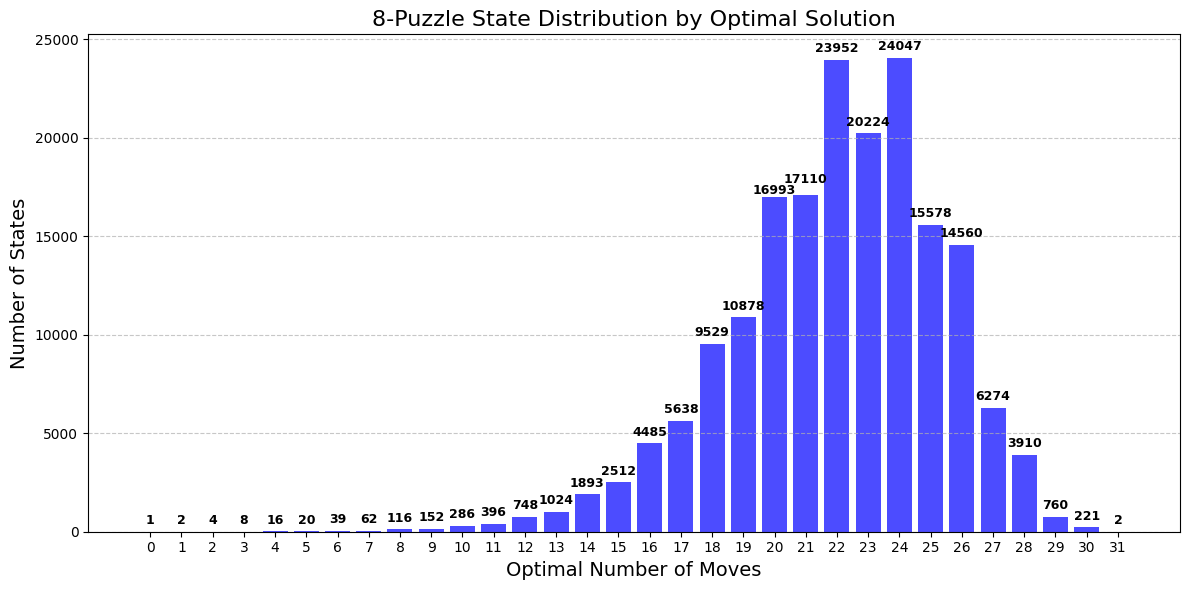

In [37]:
# Load the data from the file
histogram_data = load_histogram_data(file_path)

# Prepare the data
x = list(range(32))  # All possible moves from 0 to 31
y = [histogram_data.get(moves, 0) for moves in x]

# Plot the graph
plt.figure(figsize=(12, 6))
plt.bar(x, y, color='blue', alpha=0.7)
plt.xlabel('Optimal Number of Moves', fontsize=14)
plt.ylabel('Number of States', fontsize=14)
plt.title('8-Puzzle State Distribution by Optimal Solution', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add y values on top of the bars
for i, value in enumerate(y):
    if i == 20: plt.text(i, value, str(value), ha='center', va='bottom', fontsize=9, color='black', fontweight='bold')
    elif i == 21: plt.text(i, value + max(y) * 0.018, str(value), ha='center', va='bottom', fontsize=9, color='black', fontweight='bold')
    else: plt.text(i, value + max(y) * 0.01, str(value), ha='center', va='bottom', fontsize=9, color='black', fontweight='bold')

# Show the plot
plt.xticks(x)
plt.tight_layout()
plt.show()


In [38]:
# Print the histogram data
for moves, count in sorted(histogram_data.items()):
    print(f"{moves} moves: {count} states")

0 moves: 1 states
1 moves: 2 states
2 moves: 4 states
3 moves: 8 states
4 moves: 16 states
5 moves: 20 states
6 moves: 39 states
7 moves: 62 states
8 moves: 116 states
9 moves: 152 states
10 moves: 286 states
11 moves: 396 states
12 moves: 748 states
13 moves: 1024 states
14 moves: 1893 states
15 moves: 2512 states
16 moves: 4485 states
17 moves: 5638 states
18 moves: 9529 states
19 moves: 10878 states
20 moves: 16993 states
21 moves: 17110 states
22 moves: 23952 states
23 moves: 20224 states
24 moves: 24047 states
25 moves: 15578 states
26 moves: 14560 states
27 moves: 6274 states
28 moves: 3910 states
29 moves: 760 states
30 moves: 221 states
31 moves: 2 states


In [39]:
# Extract the data
x = list(histogram_data.keys())  # Optimal moves
y = list(histogram_data.values())  # Number of states

# Total number of states
total_states = sum(y)

# Weighted mean
mean = sum(x[i] * y[i] for i in range(len(x))) / total_states

# Weighted variance and standard deviation
variance = sum(y[i] * ((x[i] - mean) ** 2) for i in range(len(x))) / total_states
stdev = math.sqrt(variance)

# Median
cumulative_states = []
for moves, count in sorted(histogram_data.items()):
    cumulative_states.extend([moves] * count)
median_value = statistics.median(cumulative_states)

# Mode
mode_value = max(histogram_data, key=histogram_data.get)


# Print results
print(f"Total States: {total_states}")

print(f"Mean: {mean:.2f}")
print(f"Median: {median_value}")
print(f"Mode: {mode_value}")

print(f"Standard Deviation: {stdev:.2f}")
print(f"95% of states can be solved in {int(mean-2*stdev)} - {int(mean+2*stdev)} moves.")

Total States: 181440
Mean: 21.97
Median: 22.0
Mode: 24
Standard Deviation: 3.37
95% of states can be solved in 15 - 28 moves.
